### In this notebook we investigatw the pretrianed Resnet on image data

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Importing the libraries

In [2]:
import torch
import torch.backends.cudnn as cudnn

import torch.nn as nn
import torch.utils.data as Data
from torch.autograd import Function, Variable
from torch.optim import lr_scheduler
import torch.utils.model_zoo as model_zoo

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models


from pathlib import Path
import os
import copy
import math
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime
import time as time

#### Checking whether the GPU is active

In [3]:
torch.backends.cudnn.enabled

True

In [4]:
torch.cuda.is_available()

True

### Hyper Parameters

In [5]:
EPOCH= 5

BchSz=32 # BATCHSIZE

# Learning Rate
learning_rate = 0.0001


# Dropout rate
Dropout=0.1

In [6]:
# Loss calculator
criterion = nn.CrossEntropyLoss()   # cross entropy loss

Random seeds for coda and shuffling

In [7]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

Dataset paths

In [8]:
PATH = Path("/home/saman/Saman/data/Image_Data01/")
train_path = PATH / 'train' / 'Total'
valid_path = PATH / 'valid' / 'Total'
test_path = PATH / 'test' / 'Total'

### Model parameters

In [9]:
EPOCH= 5

BchSz=32 # BATCHSIZE

# Learning Rate
learning_rate = 0.0001


# Dropout rate
Dropout=0.5

### Loading data set (including augmentations)

#### Train the model with vertically and horizontally flipping

In [10]:
# Mode of transformation
transformation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
]) 

### Reading data after transformation

In [11]:
# Reading data after transformation
train_data = torchvision.datasets.ImageFolder(train_path,transform=transformation)
train_loader =torch.utils.data.DataLoader(train_data, batch_size=BchSz, shuffle=True,
                                          num_workers=8)

valid_data = torchvision.datasets.ImageFolder(valid_path,transform=transformation)
valid_loader =torch.utils.data.DataLoader(valid_data, batch_size=BchSz, shuffle=True,
                                          num_workers=8)

In [12]:
test_data = torchvision.datasets.ImageFolder(test_path, transform=torchvision.transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_data , batch_size=BchSz)

### Checking dataset

In [13]:
len(train_data), len(valid_data), len(test_data)

(12000, 4000, 4000)

In [14]:
train_data.class_to_idx

{'Canola': 0, 'Radish': 1}

A function to make a title according to classes

In [15]:
def IdxtoClass(idx):
    if idx==0:
        Class='Canola'
    if idx==1:
        Class='Radish'
    return Class

### Visualizing data

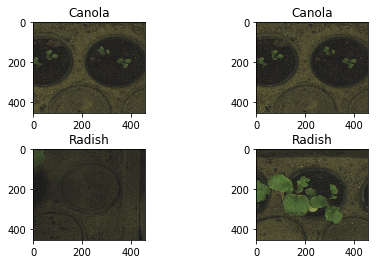

In [16]:
for i in range(2):
    img = plt.imread(train_data.imgs[i][0])
    plt.subplots_adjust(wspace=1, hspace=0.4)
    plt.subplot(2,2,i+1)   
    plt.imshow(img, aspect='auto' , cmap='viridis');
    plt.title('%s' % IdxtoClass(train_data.imgs[i][1])) #The second index if is 1 return the label
   
    img = plt.imread(train_data.imgs[-(i+1)][0])
    plt.subplot(2,2,i+3)
    plt.imshow(img, aspect='auto' , cmap='viridis');
    plt.title('%s' % IdxtoClass(train_data.imgs[-(i+1)][1])) #The second index if is 1 return the label

plt.show()

Data size

In [17]:
img = plt.imread(train_data.imgs[0][0]) # The second index if is 0 return the file name
IMSHAPE= img.shape
IMSHAPE

(456, 456, 3)

In [18]:
len(train_data.imgs)

12000

### Training and Validating

#### Training and validation function

In [19]:
EPOCH
def train_model(model, criterion, optimizer, lr_scheduler, EPOCH):
        print(str(datetime.now()).split('.')[0], "Starting training and validation...\n")
        print("====================Data and Hyperparameter Overview====================\n")
        print("Number of training examples: {} , Number of validation examples: {} ".format(len(train_data), len(valid_data)))
        print("Learning rate: {:,.5f}".format(learning_rate))
        print("================================Results...==============================\n")

        since = time.time()  #record the beginning time

        best_model = model
        best_acc = 0.0
        acc_vect =[]   

        for epoch in range(EPOCH):
            for i, (images, labels) in enumerate(train_loader):   
                images = Variable(images).cuda()
                labels = Variable(labels).cuda()

                # Forward pass
                outputs = model(images)            # model output
                loss = criterion(outputs, labels)  # cross entropy loss

                # Trying binary cross entropy
                #loss = criterion(torch.max(outputs.data, 1), labels)
                #loss = torch.nn.functional.binary_cross_entropy(outputs, labels)

                # Backward and optimize
                optimizer.zero_grad()             # clear gradients for this training step
                loss.backward()                   # backpropagation, compute gradients
                optimizer.step()                  # apply gradients

                if (i+1) % 75 == 0:               # Reporting the loss and progress every 50 step
                    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                               .format(epoch+1, EPOCH, i+1, len(train_loader), loss.item()))

            model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)

            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in valid_loader:
                    
                    images = Variable(images).cuda()
                    labels = Variable(labels).cuda()
                    
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)

                    loss = criterion(outputs, labels)
                    loss += loss.item()

                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                epoch_loss= loss / total
                epoch_acc = 100 * correct / total
                acc_vect.append(epoch_acc)

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model = copy.deepcopy(model)

                print('Validation accuracy and loss of the model on the test {} images: {} %, {:.5f}'
                      .format(len(valid_data), 100 * correct / total, loss))

            correct = 0
            total = 0
            for images, labels in train_loader:
                images = Variable(images).cuda()
                labels = Variable(labels).cuda()
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                loss = criterion(outputs, labels)
                loss += loss.item()

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            epoch_loss= loss / total
            epoch_acc = 100 * correct / total

            print('Train  accuracy and loss of the model on the test {} images: {} %, {:.5f}'
                  .format(len(train_data), epoch_acc, loss))
            print('-' * 10)

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best validation Acc: {:4f}'.format(best_acc)) 
        
        mean_acc = np.mean(acc_vect)
        print('Average accuracy on the validation {} images: {}'
              .format(len(train_data),mean_acc))
        print('-' * 10)
        return best_model, mean_acc

### Testing function

In [20]:
def test_model(model, test_loader):
    print("Starting testing...\n")
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)

    with torch.no_grad():
        correct = 0
        total = 0
        test_loss_vect=[]
        test_acc_vect=[]
        
        since = time.time()  #record the beginning time
        
        for i in range(10):
            
            Indx = torch.randperm(len(test_data))
            Cut=int(len(Indx)/10) # Here 10% showing the proportion of data is chosen for pooling
            indices=Indx[:Cut]            
            Sampler = Data.SubsetRandomSampler(indices)
            pooled_data =  torch.utils.data.DataLoader(test_data , batch_size=BchSz,sampler=Sampler)

            for images, labels in pooled_data:
                images = Variable(images).cuda()
                labels = Variable(labels).cuda()
                
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
            test_loss= loss / total
            test_accuracy= 100 * correct / total
            
            test_loss_vect.append(test_loss)
            test_acc_vect.append(test_accuracy)

            
            print('Test accuracy and loss for the {}th pool: {:.2f} %, {:.5f}'
                  .format(i+1, test_accuracy, test_loss))
            
        
        mean_test_loss = torch.mean(torch.tensor(test_loss_vect))
        mean_test_acc = torch.mean(torch.tensor(test_acc_vect))
        std_test_acc = torch.std(torch.tensor(test_acc_vect))
        
        print('-' * 10)
        print('Average of ten test accuracies on test data: {:.2f} %, loss: {:.5f}, Standard deviion of accuracy: {:.4f}'
              .format(mean_test_acc, mean_test_loss, std_test_acc))
        
        print('-' * 10)
        time_elapsed = time.time() - since
        print('Testing complete in {:.1f}m {:.4f}s'.format(time_elapsed // 60, time_elapsed % 60))
        
        print('-' * 10)
        
        return mean_test_acc, mean_test_loss, std_test_acc

### Residual network model 

#### Pretrained Resnet 18 model

In [21]:
model2 = models.resnet18(pretrained=True) #2 is number of classes
# model2= nn.Sequential(model11, nn.ReLU(),nn.Linear(1000, 2))
print(model2)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [22]:
model = models.resnet18(pretrained=False) #2 is number of classes

#model1 = nn.Sequential(*list(model.children())[:-2])
#avgpool = nn.Sequential(nn.AvgPool2d(kernel_size=7, stride=1, padding=0))
#model1 .avgpool= avgpool

#model1 = nn.Sequential(*list(model.children())[:-1])
#fc = nn.Sequential(*[nn.Linear(in_features=147456, out_features=9),nn.ReLU(),nn.Linear(9, 2)])
fc = nn.Linear(in_features=41472, out_features=2)
model.fc= fc

print(model)
model1=model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [23]:
def get_num_params(model):
    TotalParam=0
    for param in list(model.parameters()):
        nn=1
        for size in list(param.size()):
            nn = nn*size
        TotalParam += nn
    return TotalParam

In [24]:
get_num_params(model1)

11259458

#### Pretrained Resnet 18 model

In [23]:
model = model1 #2 is number of classes
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.scheduler=lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

train_model(model, criterion, optimizer, lr_scheduler, EPOCH)
test_model (model, test_loader)

2019-05-07 10:25:09 Starting training and validation...

====================Data and Hyperparameter Overview====================

Number of training examples: 12000 , Number of validation examples: 4000 
Learning rate: 0.00010
================================Results...==============================

Epoch [1/5], Step [75/375], Loss: 0.6898
Epoch [1/5], Step [150/375], Loss: 0.3399
Epoch [1/5], Step [225/375], Loss: 0.3723
Epoch [1/5], Step [300/375], Loss: 0.4685
Epoch [1/5], Step [375/375], Loss: 0.1990
Validation accuracy and loss of the model on the test 4000 images: 64.925 %, 1.91177
Train  accuracy and loss of the model on the test 12000 images: 80.75 %, 0.66494
----------
Epoch [2/5], Step [75/375], Loss: 0.6936
Epoch [2/5], Step [150/375], Loss: 0.7122
Epoch [2/5], Step [225/375], Loss: 0.6825
Epoch [2/5], Step [300/375], Loss: 0.6378
Epoch [2/5], Step [375/375], Loss: 0.6636
Validation accuracy and loss of the model on the test 4000 images: 56.9 %, 1.26001
Train  accuracy and 

(71.49276785714285, 0.00047201553, 0.2012670698983155)

In [24]:
seed= [1, 3, 7, 19, 22]

val_acc_vect=[]
test_acc_vect=[]


for ii in seed: 
    torch.cuda.manual_seed(ii)
    torch.manual_seed(ii)
    
    model = model1 #2 is number of classes
    model = model.cuda()


    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizer.scheduler=lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    
    model, val_acc= train_model(model, criterion, optimizer, lr_scheduler, EPOCH)
    testing = test_model (model, test_loader)
    test_acc= testing[0]
    
    
    val_acc_vect.append( val_acc )
    test_acc_vect.append(test_acc)
    
    mean_val_acc = np.mean(val_acc_vect)
    mean_test_acc = np.mean(test_acc_vect)
    
    
    
print('-' * 10)
print('-' * 10)
print('Average of validation accuracies on 5 different random seed: {:.2f} %, Average of testing accuracies on 5 different random seed: {:.2f} %'
      .format(mean_val_acc, mean_test_acc)) 

2019-05-07 10:36:41 Starting training and validation...

====================Data and Hyperparameter Overview====================

Number of training examples: 12000 , Number of validation examples: 4000 
Learning rate: 0.00010
================================Results...==============================

Epoch [1/5], Step [75/375], Loss: 0.5450
Epoch [1/5], Step [150/375], Loss: 0.2768
Epoch [1/5], Step [225/375], Loss: 0.4947
Epoch [1/5], Step [300/375], Loss: 0.2842
Epoch [1/5], Step [375/375], Loss: 0.2637
Validation accuracy and loss of the model on the test 4000 images: 72.95 %, 0.67463
Train  accuracy and loss of the model on the test 12000 images: 85.875 %, 0.55717
----------
Epoch [2/5], Step [75/375], Loss: 0.2534
Epoch [2/5], Step [150/375], Loss: 0.2074
Epoch [2/5], Step [225/375], Loss: 0.2562
Epoch [2/5], Step [300/375], Loss: 0.2579
Epoch [2/5], Step [375/375], Loss: 0.2062
Validation accuracy and loss of the model on the test 4000 images: 71.05 %, 2.25083
Train  accuracy and

Epoch [5/5], Step [150/375], Loss: 0.0740
Epoch [5/5], Step [225/375], Loss: 0.1212
Epoch [5/5], Step [300/375], Loss: 0.0316
Epoch [5/5], Step [375/375], Loss: 0.0365
Validation accuracy and loss of the model on the test 4000 images: 71.875 %, 2.96118
Train  accuracy and loss of the model on the test 12000 images: 98.575 %, 0.02490
----------
Training complete in 11m 12s
Best validation Acc: 73.100000
Average accuracy on the validation 12000 images: 70.11
----------
Starting testing...

Test accuracy and loss for the 1th pool: 71.25 %, 0.00719
Test accuracy and loss for the 2th pool: 72.50 %, 0.00231
Test accuracy and loss for the 3th pool: 73.00 %, 0.00330
Test accuracy and loss for the 4th pool: 73.19 %, 0.00088
Test accuracy and loss for the 5th pool: 73.15 %, 0.00052
Test accuracy and loss for the 6th pool: 73.25 %, 0.00133
Test accuracy and loss for the 7th pool: 73.54 %, 0.00026
Test accuracy and loss for the 8th pool: 73.94 %, 0.00065
Test accuracy and loss for the 9th pool: 73